In [394]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

#data_mapping = pd.read_csv("./mapping.csv",na_values=['?','Unknown/Invalid'],low_memory=False)
#admission_type_id_des = data_mapping.iloc[0:8].reset_index(drop= True)
#discharge_type_id_des = data_mapping.iloc[9:40].reset_index(drop= True)
#admission_source_id_des = data_mapping.iloc[41:].reset_index(drop= True)

#for i in [discharge_type_id_des,admission_source_id_des] :
#    i.columns = [i.iloc[0][0],'description']
#    i.drop(index=i.index[0],axis=0,inplace=True)
#   i[i.columns[0]] = i[i.columns[0]].astype(int)
#   i = i.set_index(i.columns[0])
    
#discharge_type_id_des = discharge_type_id_des.set_index(discharge_type_id_des.columns[0]).sort_index()
#admission_source_id_des = admission_source_id_des.set_index(admission_source_id_des.columns[0]).sort_index()


The objective of our analysis is to determine whether a patient will be readmitted to the hospital within a 30-day timeframe. The variable of interest encompasses three categories, namely, readmission within less than 30 days, readmission after more than 30 days, and no readmission. To facilitate binary classification, we have combined the categories of no readmission and readmission after more than 30 days into a single category, labeled as "0." The category of readmission within less than 30 days has been labeled as "1."

# Exploratory data Analysis and preprocessing


## Dealing with Missing Values

In [395]:
raw_data = pd.read_csv("./data.csv",na_values=['?','Unknown/Invalid'],low_memory=False)

def missing_data_info(df):
    # some stats about the missing values in the data 
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0].index.tolist()

    print("*************************Missing Data info***************************************")
    print("Length of All data : ",len(df ))
    print("Length of data with non nulls : ",len(df.dropna()))
    print("Number of columns with at least one null value:",len(null_cols))
    if len(null_cols) > 0:
        print("Column names and their number of missing values:")
        adf = df[null_cols]
        adf_null_counts = adf.isnull().sum()
        print(adf_null_counts)
    print("****************************************************************")
    
missing_data_info(raw_data)


*************************Missing Data info***************************************
Length of All data :  101766
Length of data with non nulls :  1043
Number of columns with at least one null value: 8
Column names and their number of missing values:
race                  2273
gender                   3
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64
****************************************************************


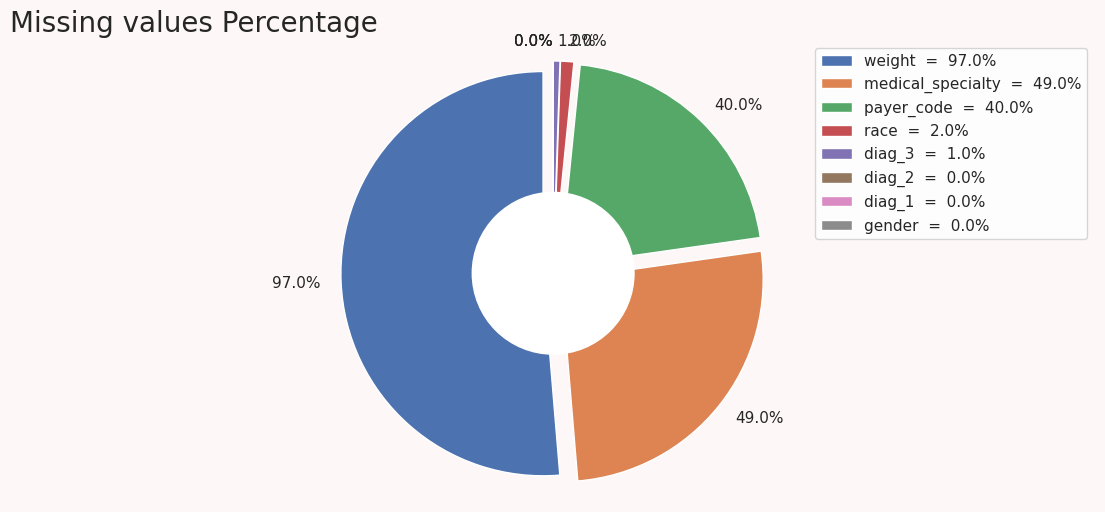

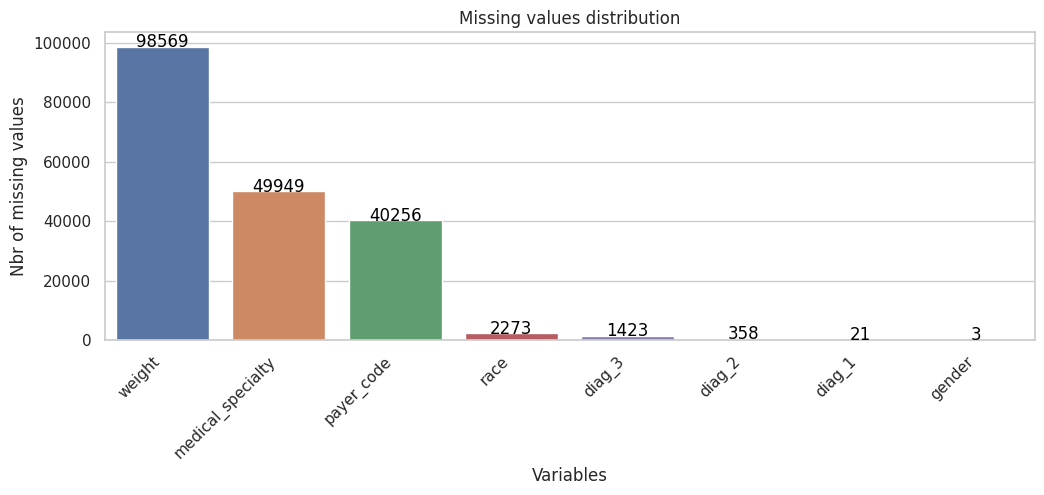

,Variables,total_missing_values,missing_values_rate(%),Nbr_of_unique_values
0,weight,98569,97.0,10
1,medical_specialty,49949,49.0,73
2,payer_code,40256,40.0,18
3,race,2273,2.0,6
4,diag_3,1423,1.0,790
5,diag_2,358,0.0,749
6,diag_1,21,0.0,717
7,gender,3,0.0,3


In [396]:

def bar_chart_plotter(df,x,y,title):
    # Set the style and palette
    sns.set(style="whitegrid")
    colors = sns.color_palette("deep")
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=df[x], y=df[y], data=df, palette=colors)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Nbr of missing values")
    # Customize the x-axis labels
    plt.xticks(rotation=45, ha="right")
    # Add the values as labels above each bar
    for index, row in df.iterrows():
        ax.text(index, row[y] + 5, str(row[y]), color='black', ha="center")
    # Show the chart
    plt.show()

def pie_chart_plotter(df,x,y, title, labels = None,legend = None):  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    num_colors = len(df[y])
    color_palette = sns.color_palette("deep", num_colors)
    colors = color_palette.as_hex()
    
    explode = [0.05]*len(df[y])
   
    ax.pie(df[y], colors=colors ,labels = labels,startangle=90, explode=explode, 
                                  labeldistance=1.1, radius=1)
   
    ax.set_title(title, fontsize=20, loc= 'left')
    
    ax.legend(legend, loc="best")
    # set text properties of labels
    #plt.setp(labels, fontsize=12, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='black'))
   
    # create a circle at the center of the pie
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig.gca().add_artist(centre_circle)
    # set equal aspect ratio
    ax.axis('equal')
    # show the plot
    plt.show()



def visualize_missing_data(df):
    data_length = len(df)
    null_counts = df.isnull().sum()
    null_cols =null_counts[null_counts > 0]

    null_stats_df = pd.DataFrame(null_cols, columns=["total_missing_values"])
    null_stats_df[' missing_values_rate(%)'] = ((null_stats_df['total_missing_values'] / data_length ) * 100).round()

    nbr_uniquevals = [len(df[col].unique()) for col in null_cols.index.tolist()]
    uniquevals = [df[col].unique() for col in null_cols.index.tolist()]
    null_stats_df['Nbr_of_unique_values'] = nbr_uniquevals
   
    #pie chart

    null_stats_df = null_stats_df.sort_values(by='total_missing_values', ascending = False)

    null_stats_df.index.name = 'Variables'
    percents = null_stats_df[null_stats_df.columns[1]].astype(str) + '%'
    legend = null_stats_df.index + '  =  '+ percents 

    pie_chart_plotter(null_stats_df,null_stats_df.index,null_stats_df.columns[1],'Missing values Percentage',percents,legend)
   
    #bar chart 
    null_stats_df.reset_index(inplace=True)
    bar_chart_plotter(null_stats_df,null_stats_df.columns[0],null_stats_df.columns[1],'Missing values distribution')
    
    return null_stats_df

visualize_missing_data(raw_data)

- Variables race,gender,diag_1,diag_2,diag_3 have fairly low missing values compaired to others,so we decided to impute the missing values with the most common value.
- Variables gender, payer_code and medical_specialty have respectively 97%,40%,49% missing values so there is no usefulness in filling them, we decided to drop them.
 

In [397]:
# Impute columns with fairly low number of missing values with most common value 
columns_to_impute = ['race', 'gender','diag_1','diag_2','diag_3']
for col in columns_to_impute : 
    most_comon_value = raw_data[col].mode()[0]
    raw_data[col] = raw_data[col].fillna(most_comon_value)

# drop gender, payer_code and medical_specialty
raw_data = raw_data.drop(['weight','payer_code','medical_specialty'], axis = 1) 

## Data visualization and manipulation


### Target Variable distribution

In [398]:
raw_data.readmitted = [1 if val =='<30' else 0 for val in raw_data.readmitted]

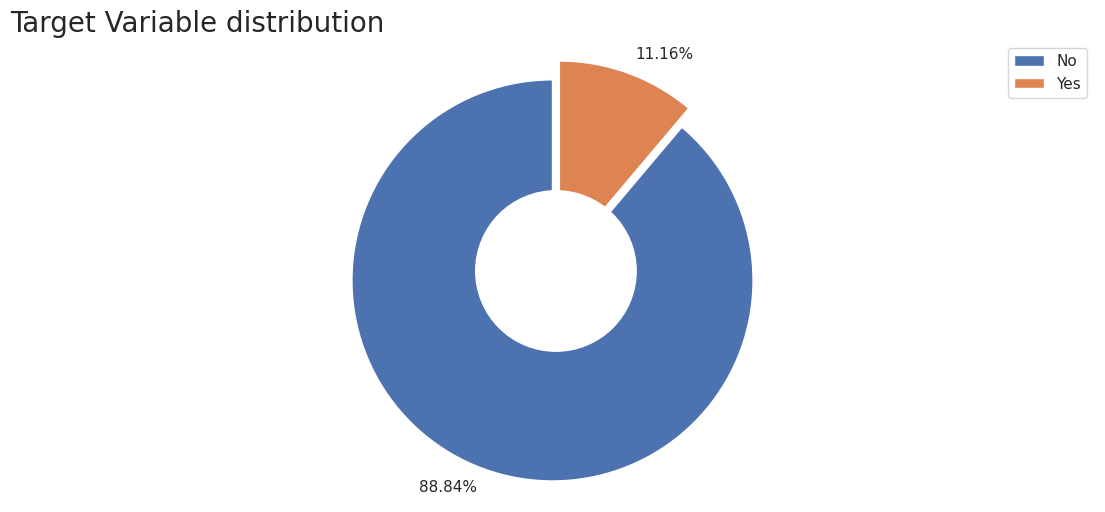

In [399]:
values = raw_data.readmitted.value_counts().tolist()
legend = ['No','Yes']
labels = [ str(round((value / len(raw_data) * 100),2))+'%' for value in values] 
df = pd.DataFrame({'Values' :values, 'labels' :labels })
pie_chart_plotter(df ,'labels', 'Values','Target Variable distribution',labels,legend)


### Feature engineering

In [400]:
def plot_feature_distribution(df,feature):
    sns.set(style='whitegrid', rc={'axes.facecolor': '#ffffff','figure.facecolor': '#fdf8f7','axes.grid': False})
    
    plt.figure(figsize=(10,6))
    feature_counts = df[feature].value_counts()
   
    ax = sns.countplot(x=feature, data=raw_data, palette='pastel', order = feature_counts.index )
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of '+ feature, fontsize=16)
    
    sns.despine(left=True)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # add count values for each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10),
                    textcoords = 'offset points', fontsize=12)
    plt.show()


def plot_prob_density(df,col):
    fig = plt.figure(figsize=(10,5))

    #readmitted = 0
    ax = sns.kdeplot(df.loc[(df.readmitted == 0), col],
                    color = "r", shade = True,label = "Not Readmitted")
    #readmitted = 1
    ax = sns.kdeplot(df.loc[(df.readmitted == 1), col],
                    color = "g", shade = True, label = "Readmitted")
    
    ax.legend(loc="upper right")

    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(col+" -  Readmission")
    plt.show()

#### Race

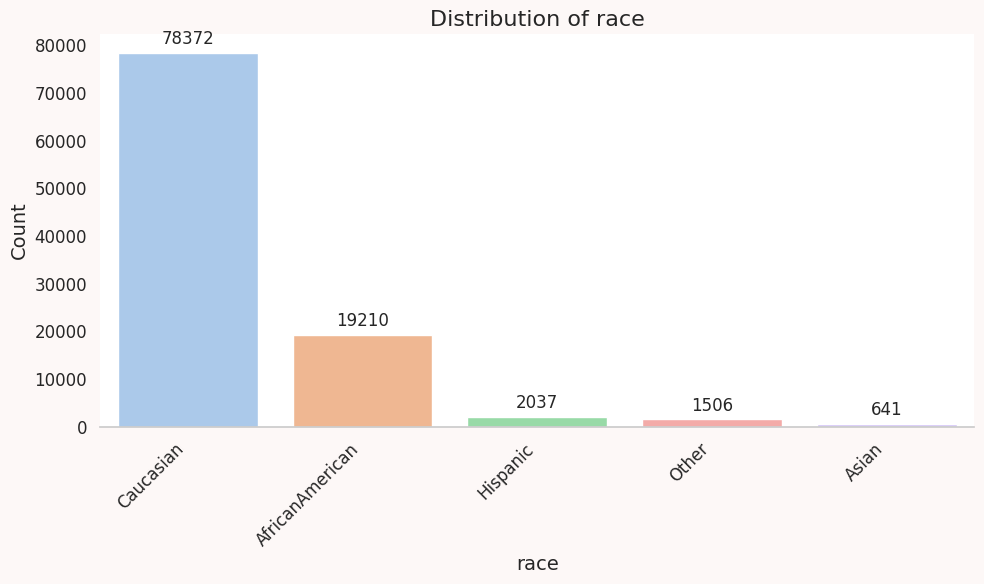

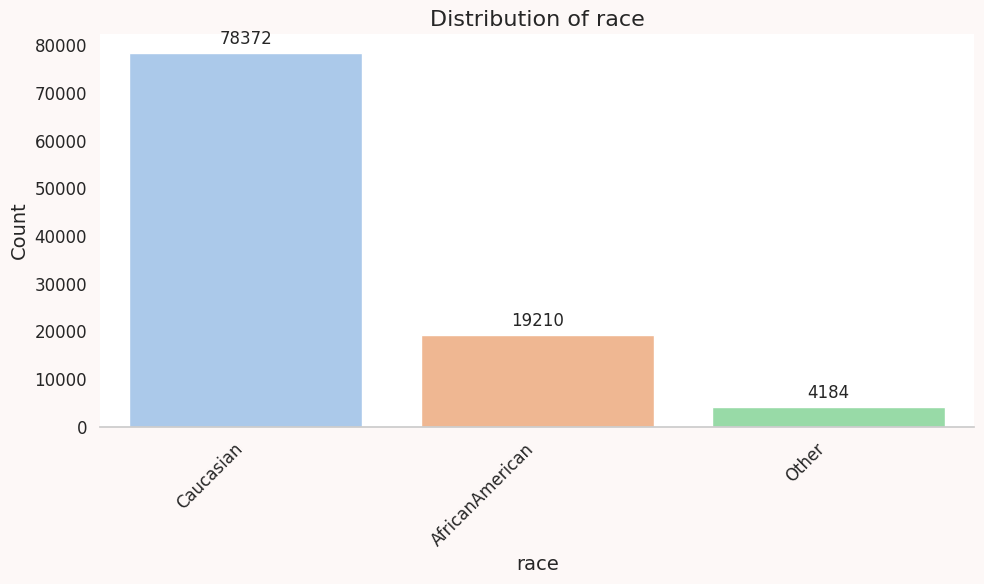

In [401]:
plot_feature_distribution(raw_data,'race')
mapping = {"Asian":"Other","Hispanic":"Other"}
raw_data.race = raw_data.race.replace(mapping)
plot_feature_distribution(raw_data,'race')

#### Age

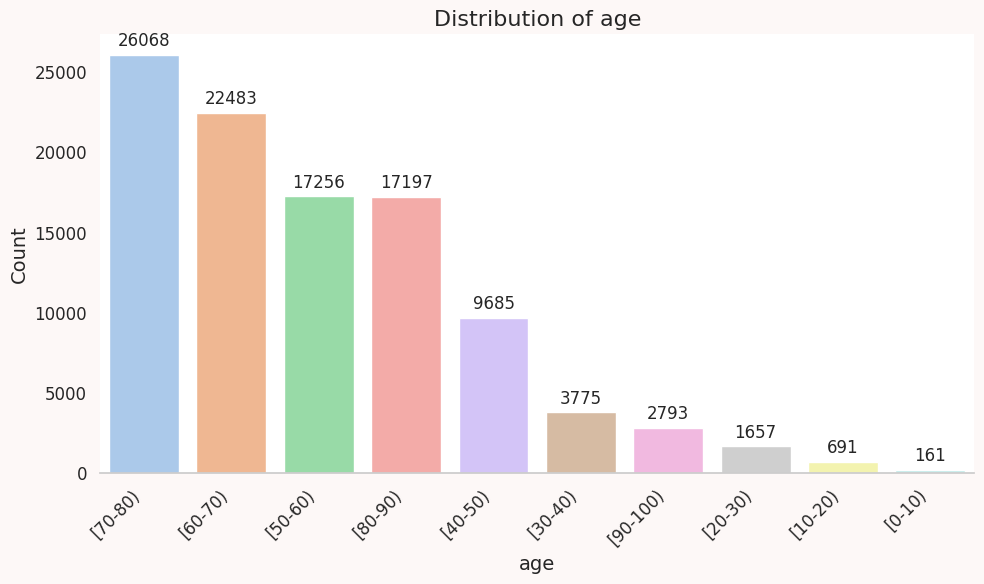

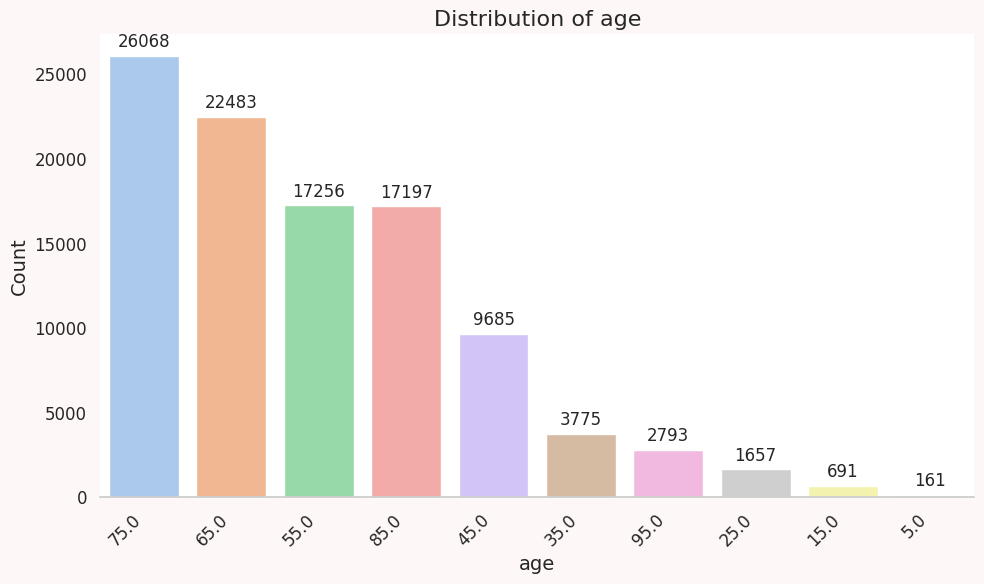

In [402]:

plot_feature_distribution(raw_data,'age')
raw_data['age'].head(5)
raw_data['age'] = raw_data['age'].apply(lambda x : ( int(x.split('-')[0].strip('[')) +  int(x.split('-')[1].strip(')')) ) / 2 ) 
raw_data['age'].head(5)
plot_feature_distribution(raw_data,'age')

#### Gender

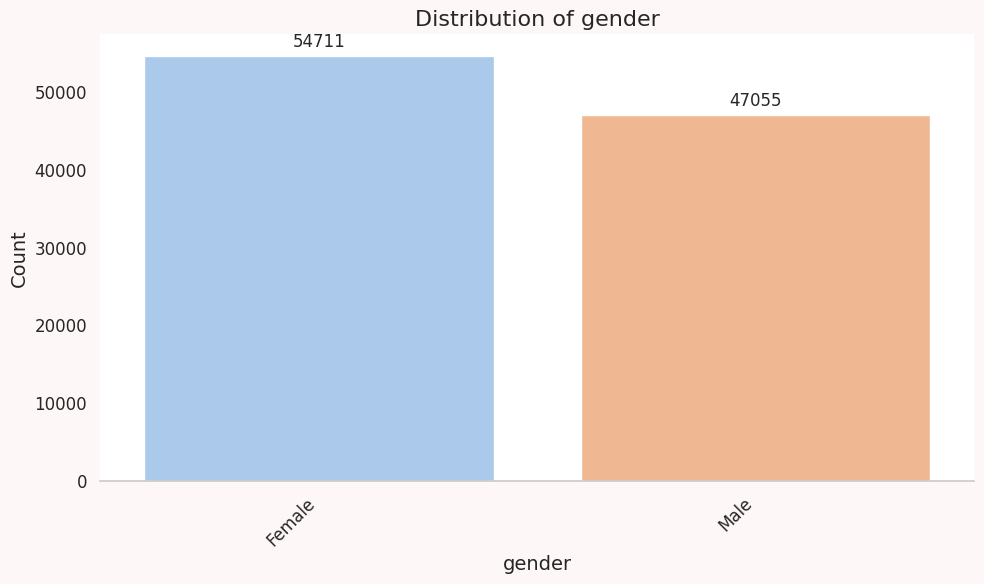

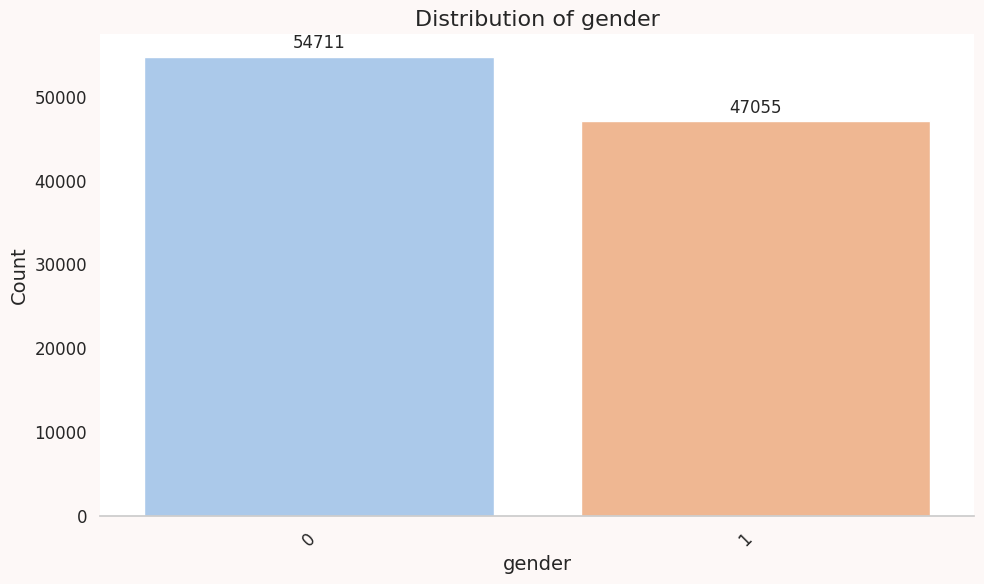

In [403]:
plot_feature_distribution(raw_data,'gender')
mapping = {"Female":0,"Male":1}
raw_data.gender = raw_data.gender.replace(mapping)
plot_feature_distribution(raw_data,'gender')

#### Admission type ID 

- Emergency : 1
- Urgent : 2
- Elective : 3
- Newborn : 4
- Not Available : 5
- NULL : 6
- Trauma Center : 7
- Not Mapped : 8

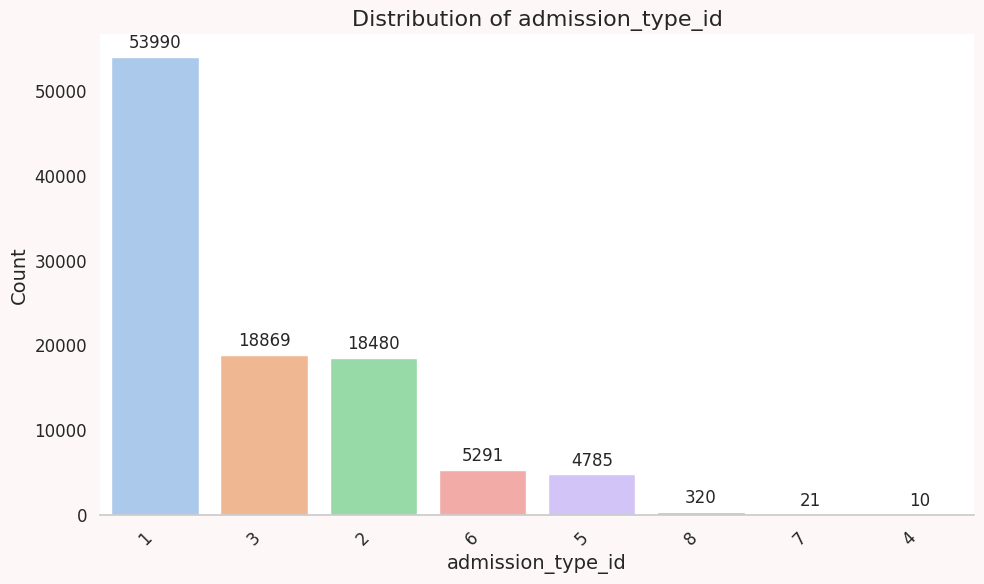

In [404]:
plot_feature_distribution(raw_data,'admission_type_id')

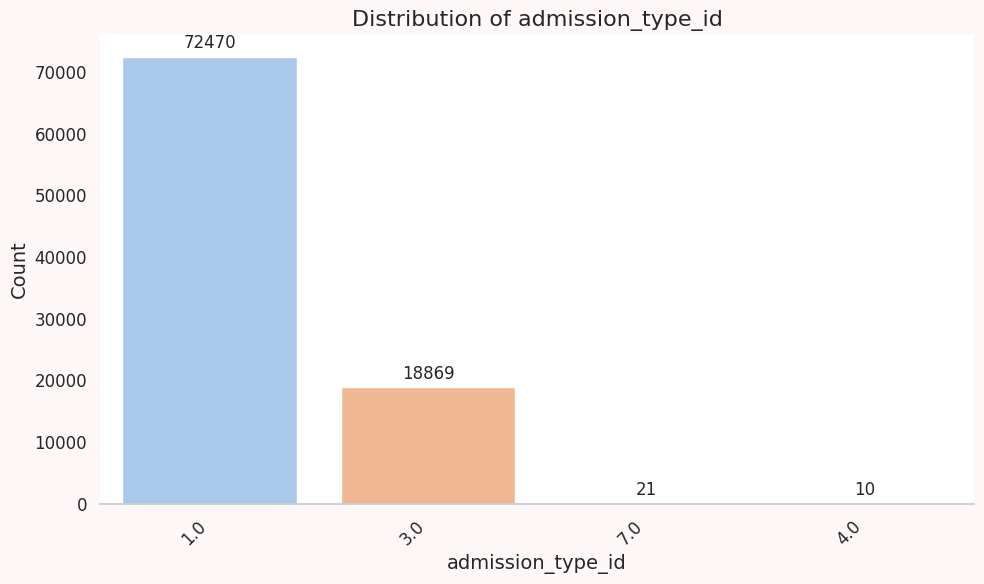

In [405]:

mapping = {2:1, 5:np.nan,6:np.nan,8:np.nan}
raw_data['admission_type_id'] = raw_data['admission_type_id'].replace(mapping)
plot_feature_distribution(raw_data,'admission_type_id')

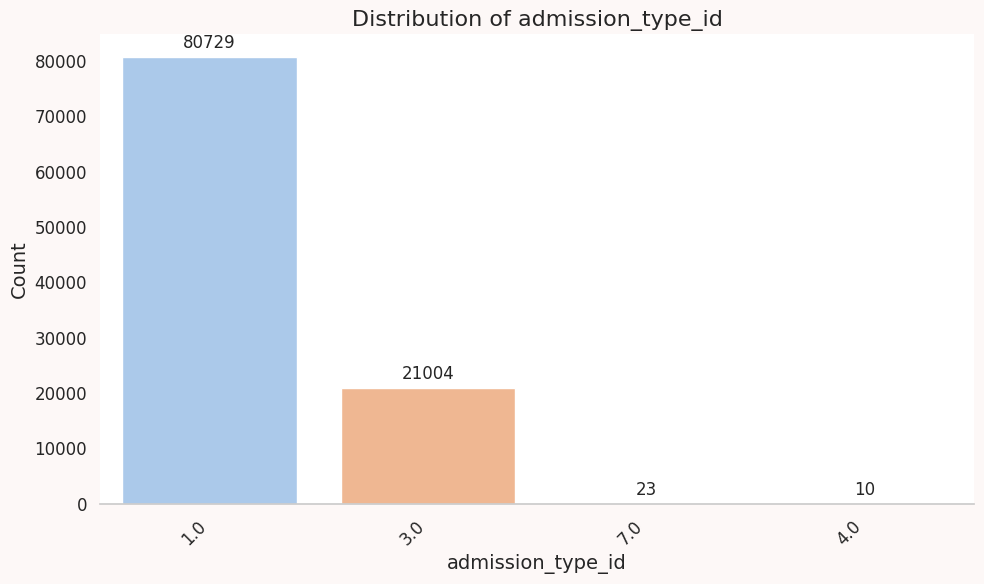

In [406]:

def fillna_distribution(df,col):
    #fill missing values acording to distribution of non_missing values 
    value_counts = df[col].value_counts(normalize=True)
    missing_mask = df[col].isnull()
    missing_count = missing_mask.sum()
    fill_values = np.random.choice(value_counts.index, size=missing_count, p=value_counts.values)
    df.loc[missing_mask, col] = fill_values
    df[col].value_counts(normalize=True)

fillna_distribution(raw_data,'admission_type_id')
plot_feature_distribution(raw_data,'admission_type_id')


#### Discharge Disposition ID

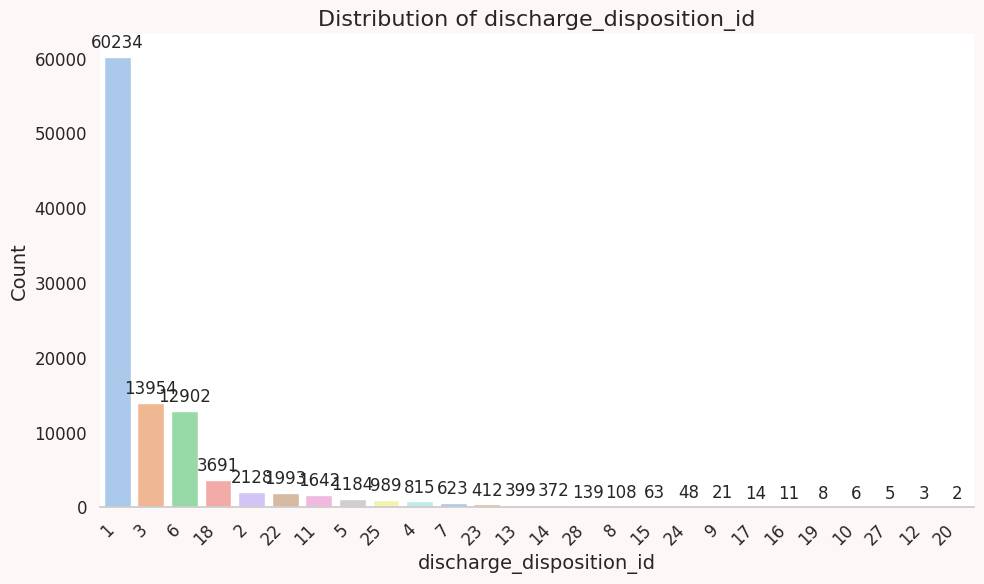

In [407]:
plot_feature_distribution(raw_data,'discharge_disposition_id')

Number of catergories:  26
Number of missing values:  14194


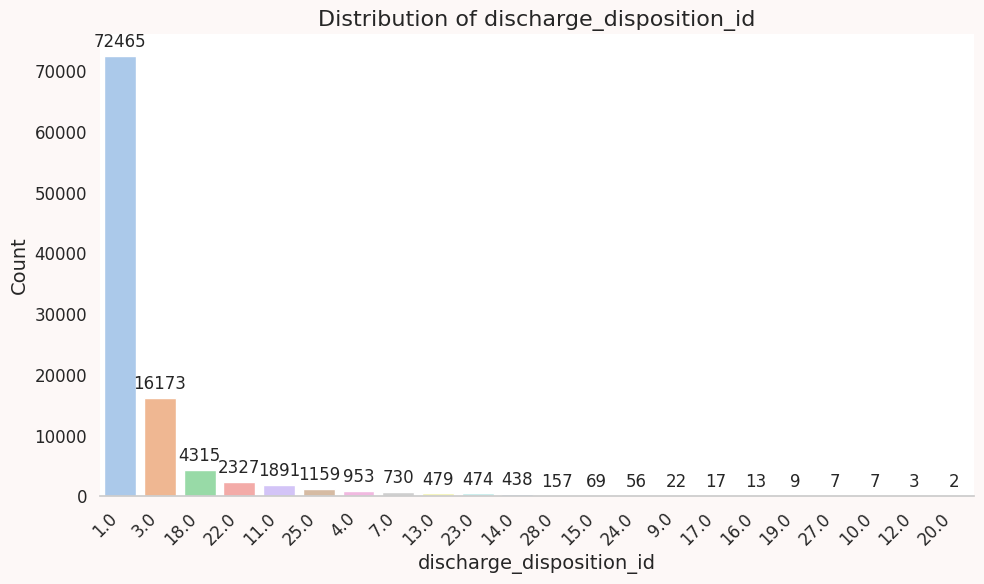

In [408]:
# fill nulls according to distribution of values
print('Number of catergories: ',len(raw_data['discharge_disposition_id'].unique()) )

mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan }
raw_data['discharge_disposition_id'] = raw_data['discharge_disposition_id'].replace(mapping)

print('Number of missing values: ',raw_data['discharge_disposition_id'].isnull().sum())
fillna_distribution(raw_data,'discharge_disposition_id')
plot_feature_distribution(raw_data,'discharge_disposition_id')


In [409]:
len(raw_data['discharge_disposition_id'].unique())
print('Number of catergories After filling null values: ',len(raw_data['discharge_disposition_id'].unique()) )


Number of catergories After filling null values:  22


#### Admission Source ID

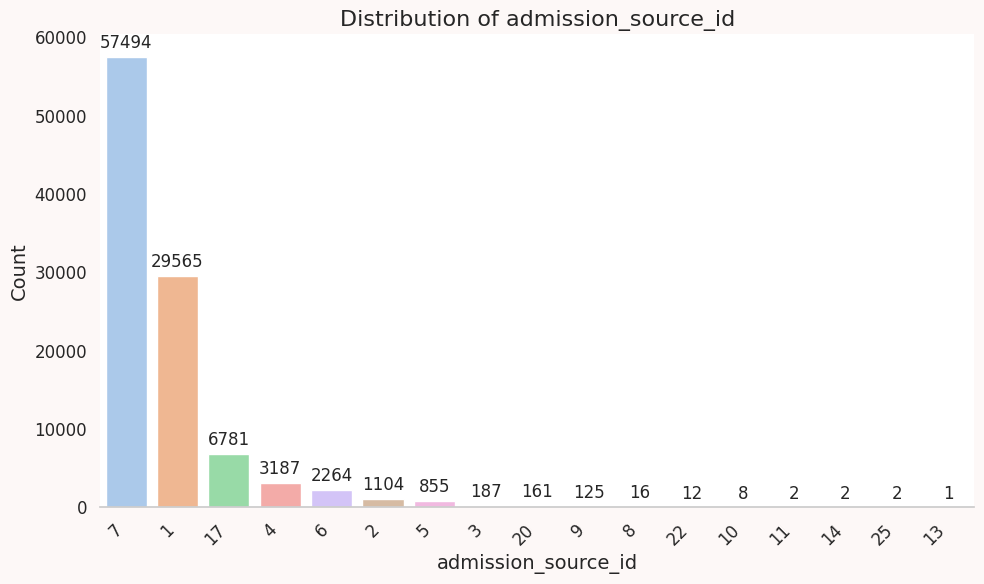

In [410]:
plot_feature_distribution(raw_data,'admission_source_id')

Number of missing values:  3135


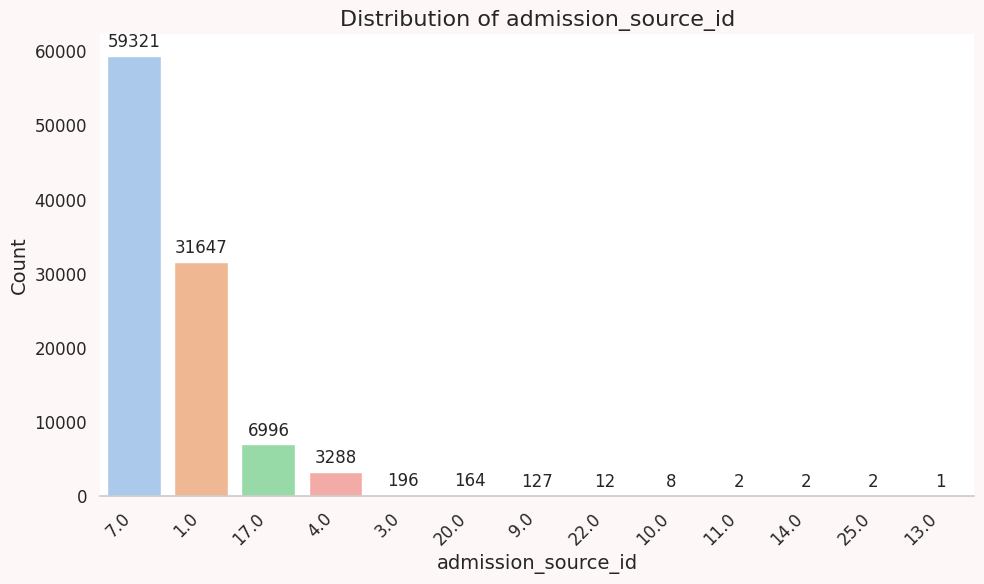

In [411]:
# fill nulls according to distribution of values
mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan ,'Not available':np.nan}
raw_data['admission_source_id'] = raw_data['admission_source_id'].replace(mapping)
print('Number of missing values: ',raw_data['admission_source_id'].isnull().sum())
fillna_distribution(raw_data,'admission_source_id')
plot_feature_distribution(raw_data,'admission_source_id')

#### Time in Hospital

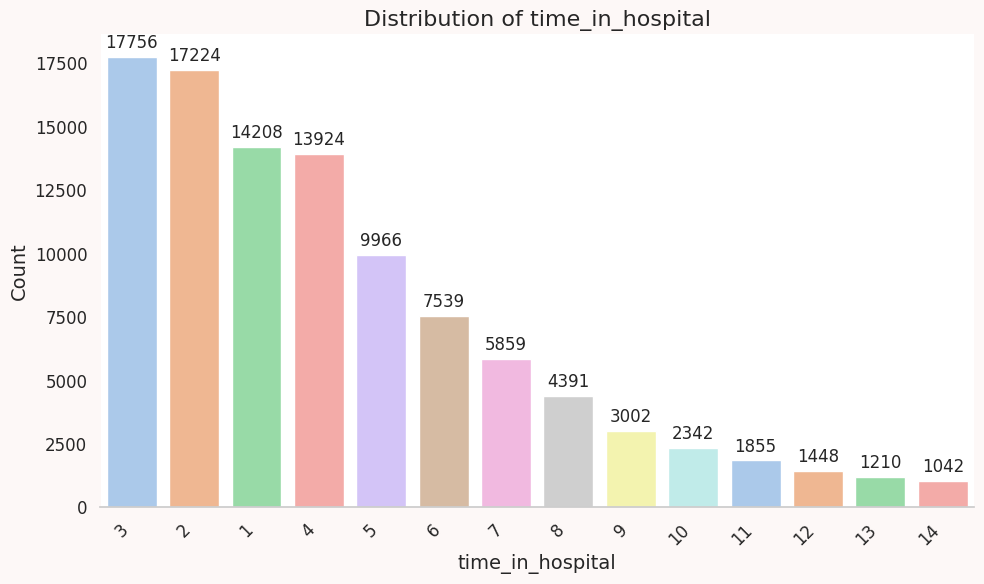

In [412]:
plot_feature_distribution(raw_data,'time_in_hospital')

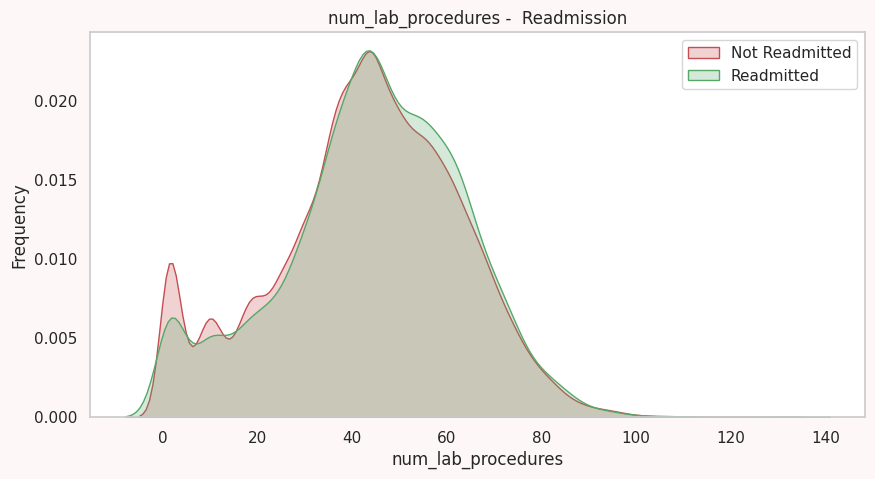

In [413]:
plot_prob_density(raw_data,'num_lab_procedures')

#### Number of Procedures

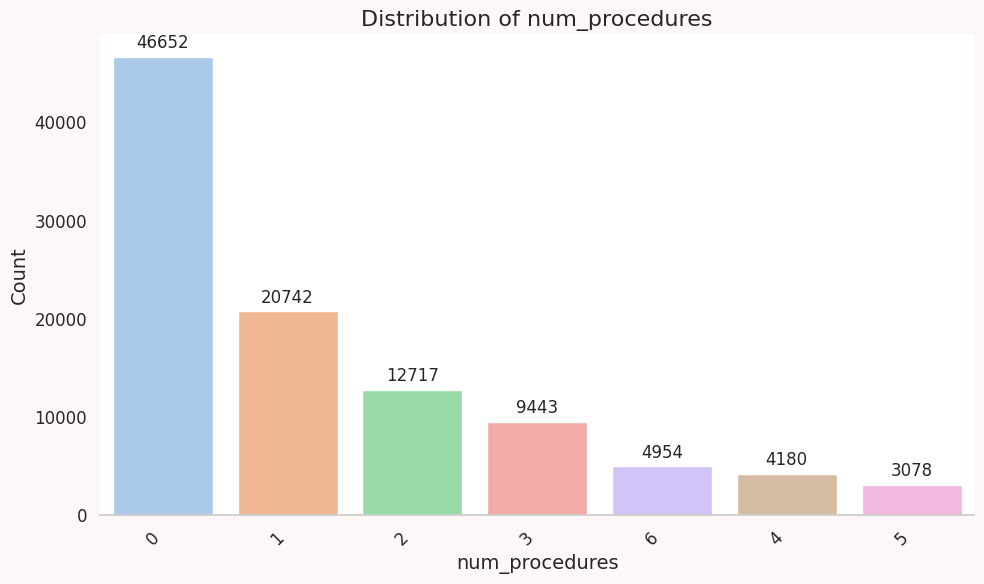

In [414]:
plot_feature_distribution(raw_data,'num_procedures')

#### Number of lab procedures

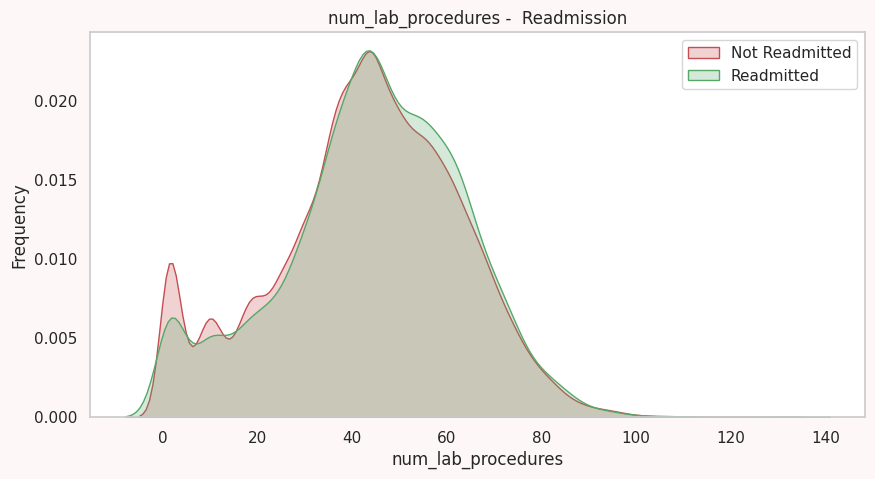

In [415]:
plot_prob_density(raw_data,'num_lab_procedures')

#### Number of Medications

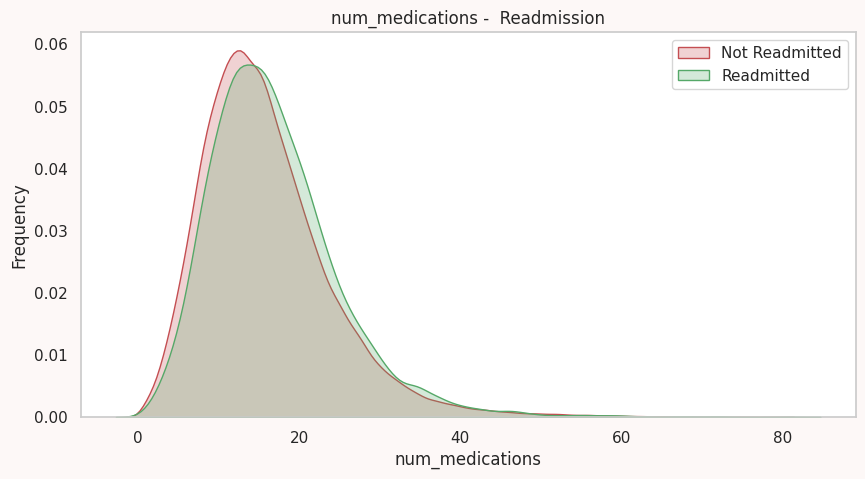

In [416]:
plot_prob_density(raw_data, 'num_medications') 

In [417]:
raw_data['num_medications']

0          1
1         18
2         13
3         16
4          8
          ..
101761    16
101762    18
101763     9
101764    21
101765     3
Name: num_medications, Length: 101766, dtype: int64

#### Diag1, Diag2 and Diag3

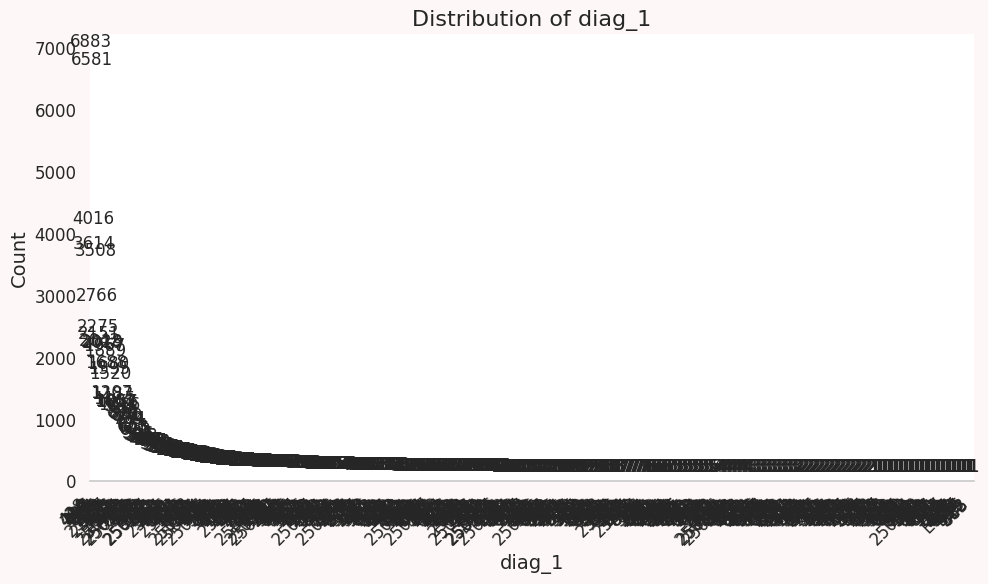

In [418]:
plot_feature_distribution(raw_data,'diag_1')

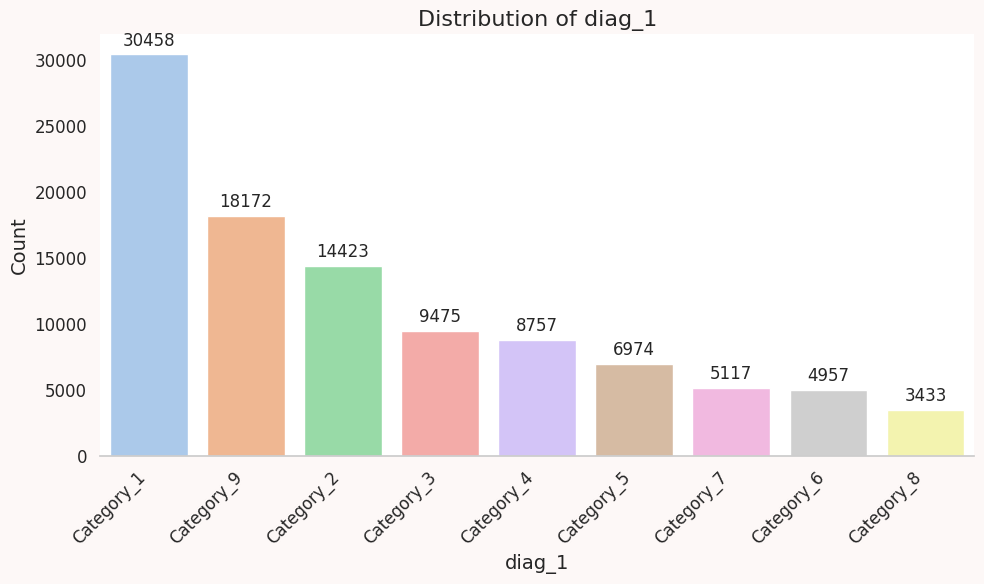

In [419]:
def diagnoses_categorization(col):
    # define the regular expression pattern to match ICD9 codes 
    circulatory = "^3[9-9]\d|4[0-5]\d|785$"
    respiratory = "^46[0-9]|4[7-9][0-9]|5[01][0-9]|786$"
    digestive = "^(52[0-9]|5[3-7][0-9]|787)$"
    Diabetes = "^250\.\d{1,2}|250$"
    Injury = "^(80[0-9]|8[1-9][0-9]|9[0-9]{2})$"
    Musculoskeletal = "^(71[0-9]|7[23][0-9])$"
    Genitourinary = "^(58[0-9]|59[0-9]|6[0-2][0-9]|788)$"
    Neoplasms =  "^(14[0-9]|1[5-9][0-9]|2[0-3][0-9])$"

    other = ["^(79[0-9]|780|781|784|789|783)$",
                "^(24[0-9]|25[1-9]|2[67][0-9])$",
                "^(68[0-9]|69[0-9]|70[0-9]|782)$",
                "^([1-9]|[1-9][0-9]|1[0-3][0-9])$",
                "^(29[0-9]|3[01][0-9])$",
                "^(E|V)\d+",
                "^(28[0-9])$" ,
                "^(32[0-9]|3[3-5][0-9])$",
                "^(63[0-9]|6[4-7][0-9])$",
                "^(36[0-9]|3[78][0-9])$",
                "^(74[0-9]|75[0-9])$",
                "^365\.\d{1,2}$"   
                ]


    cats = [circulatory,respiratory,digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms]

    for cat in cats:  
        raw_data[col] = raw_data[col].str.replace(cat, 'Category_'+str(cats.index(cat)+1), regex=True)

    for o in other:
        raw_data[col] = raw_data[col].str.replace(o, 'Category_'+str(9), regex=True)

diagnoses_categorization('diag_1')
plot_feature_distribution(raw_data,'diag_1')



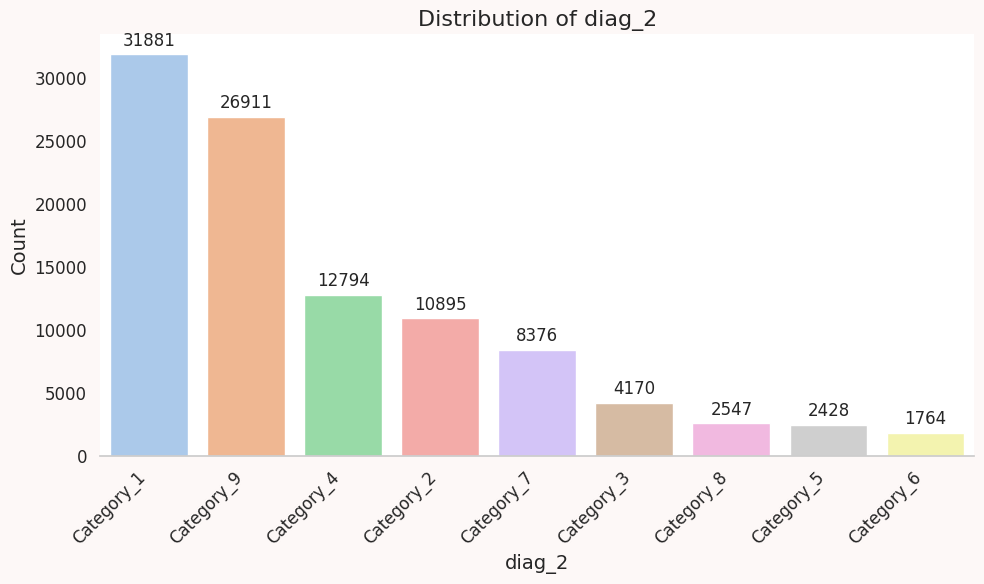

In [420]:
diagnoses_categorization('diag_2')
plot_feature_distribution(raw_data,'diag_2')

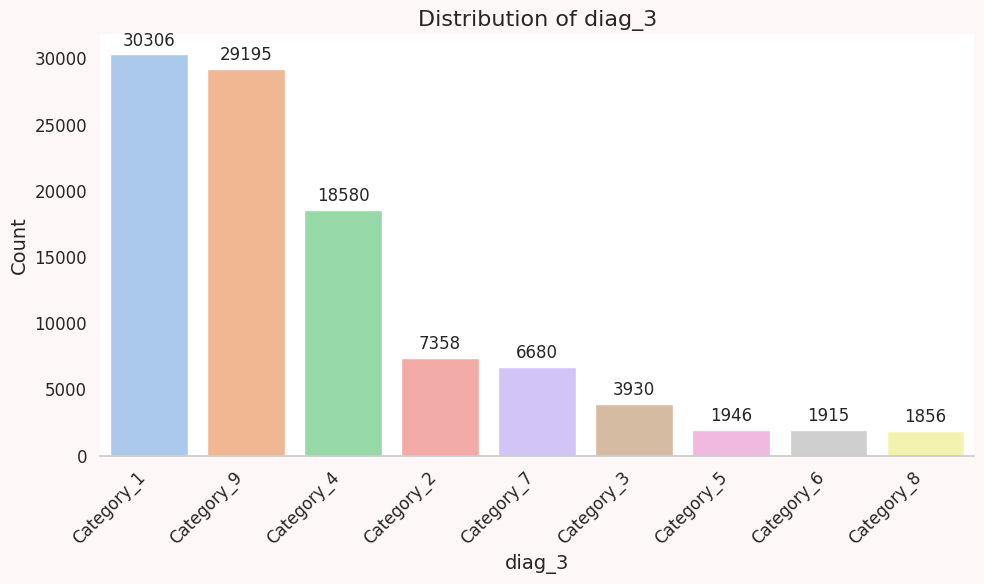

In [421]:
diagnoses_categorization('diag_3')
plot_feature_distribution(raw_data,'diag_3')

#### Change

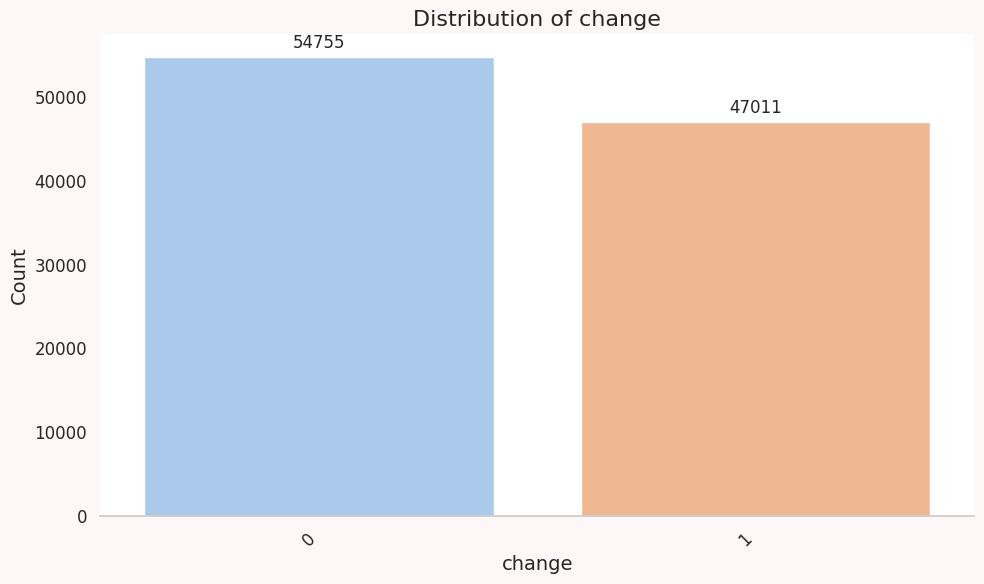

In [422]:
mapping = {'Ch':1,'No':0}
raw_data['change'] = raw_data['change'].replace(mapping)
plot_feature_distribution(raw_data,'change')


#### Glucose Serum Test Result

Indicates the range of the result or if the test was not taken.
Values:

- “>200,”
- “>300,”
- “normal,”
- “none” if not measured

remapped to :

- 1 : abnormal
- 0 : normal
- 2 : not_measured

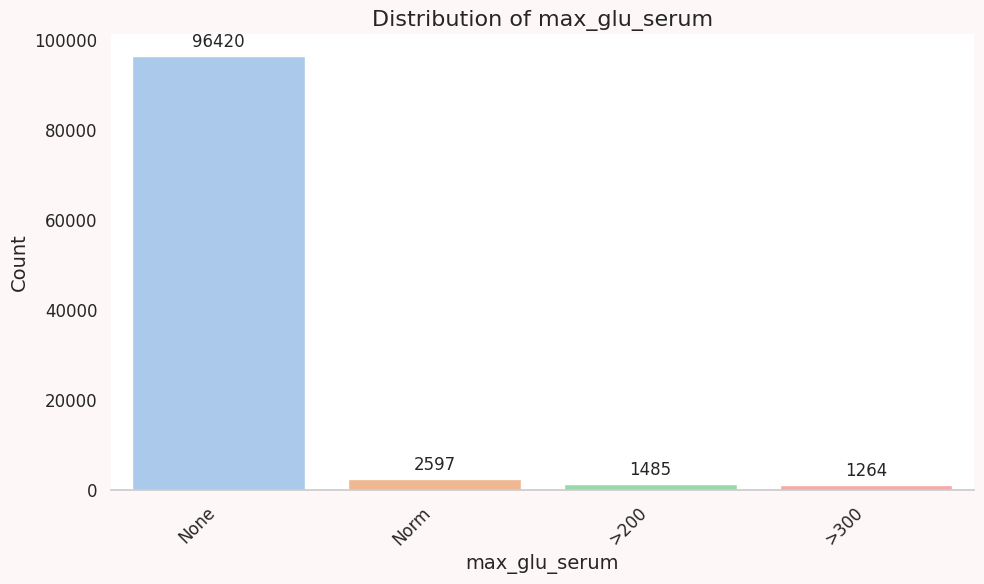

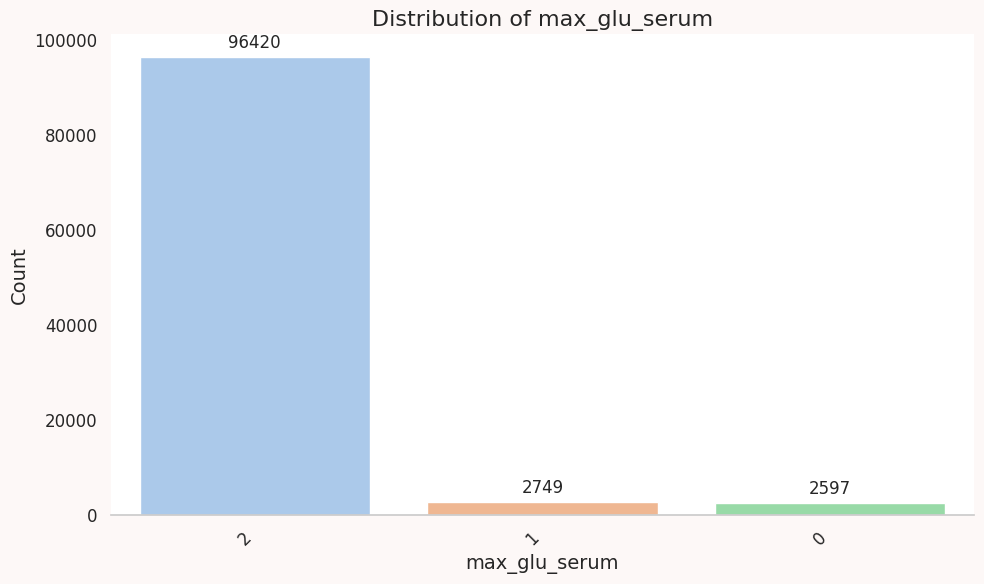

In [423]:


plot_feature_distribution(raw_data,'max_glu_serum')
mapping = {'>200':1,'>300':1,'Norm':0,'None':2}
raw_data.max_glu_serum = raw_data.max_glu_serum.replace(mapping)

plot_feature_distribution(raw_data,'max_glu_serum')


#### A1c test result¶



Indicates the range of the result or if the test was not taken.

- “>8” if the result was greater than 8%,
- “>7” if the result was greater than 7% but less than 8%, “normal”
- if the result was less than 7%, and “none” if not measured.

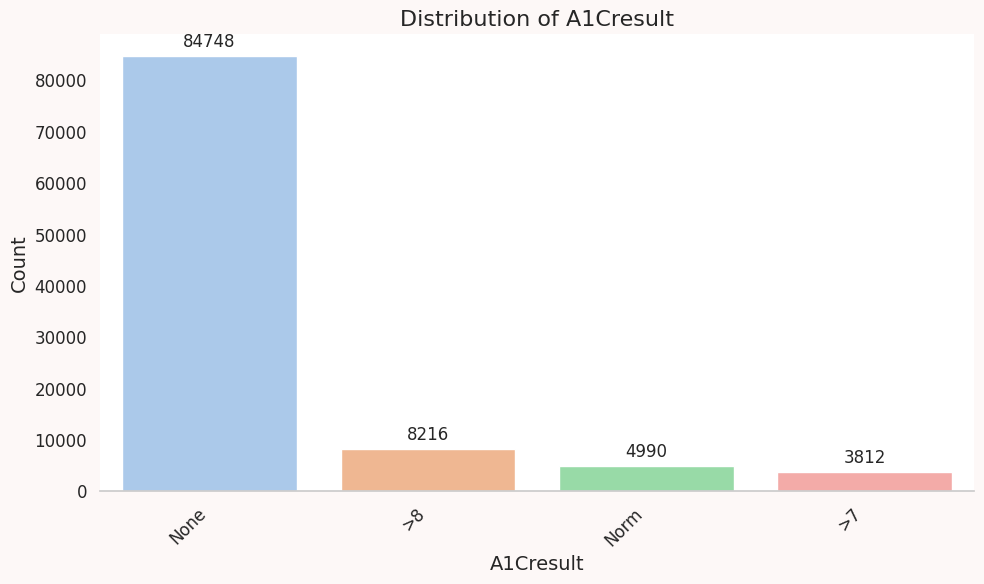

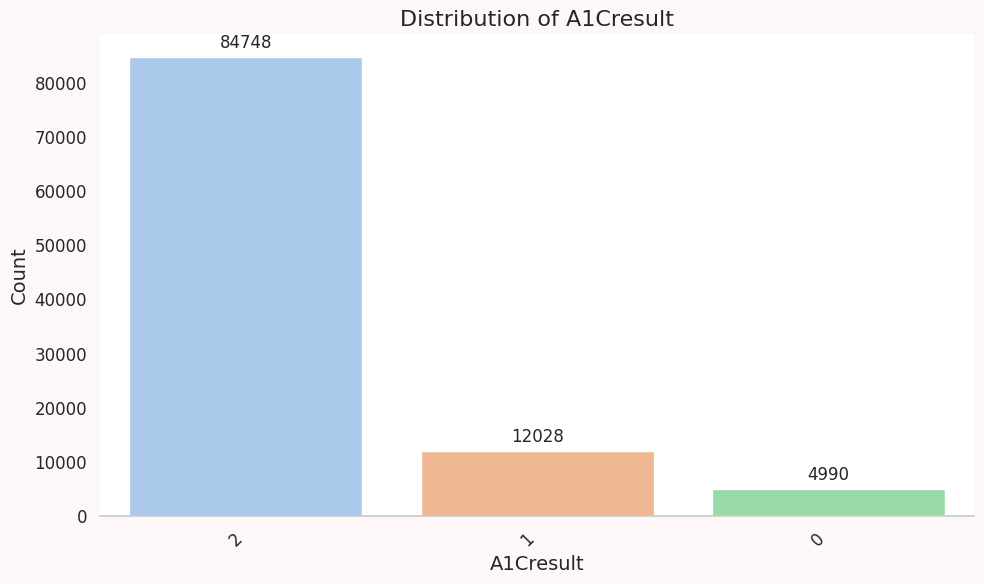

In [424]:
plot_feature_distribution(raw_data,'A1Cresult')
mapping = {'>8':1,'>7':1,'Norm':0,'None':2}
raw_data.A1Cresult = raw_data.A1Cresult.replace(mapping)
plot_feature_distribution(raw_data,'A1Cresult')

#### Diabetes medications¶

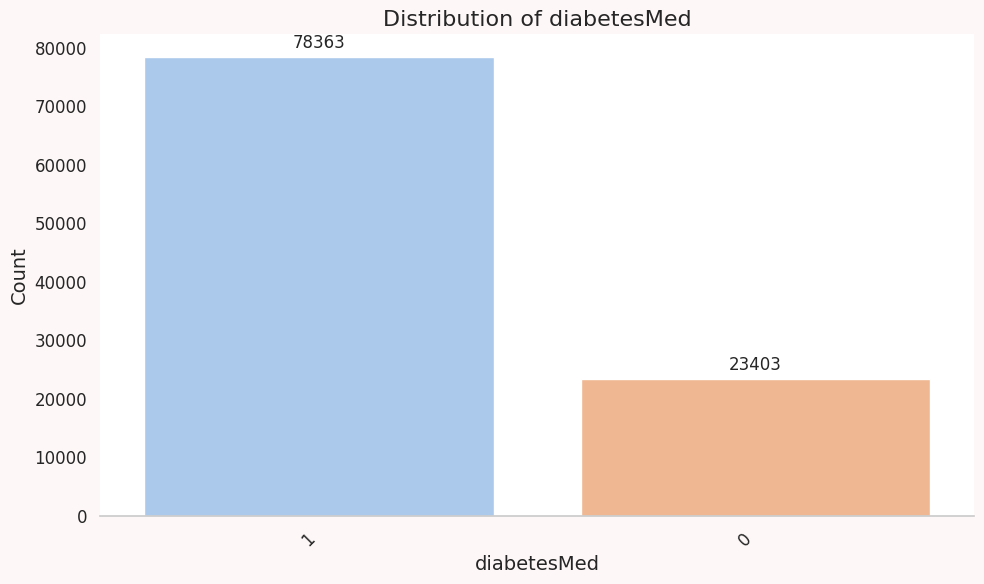

In [425]:
mapping = {'Yes':1,'No':0}
raw_data['diabetesMed'] = raw_data['diabetesMed'].replace(mapping)
plot_feature_distribution(raw_data,'diabetesMed')

#### Number of diagnoses

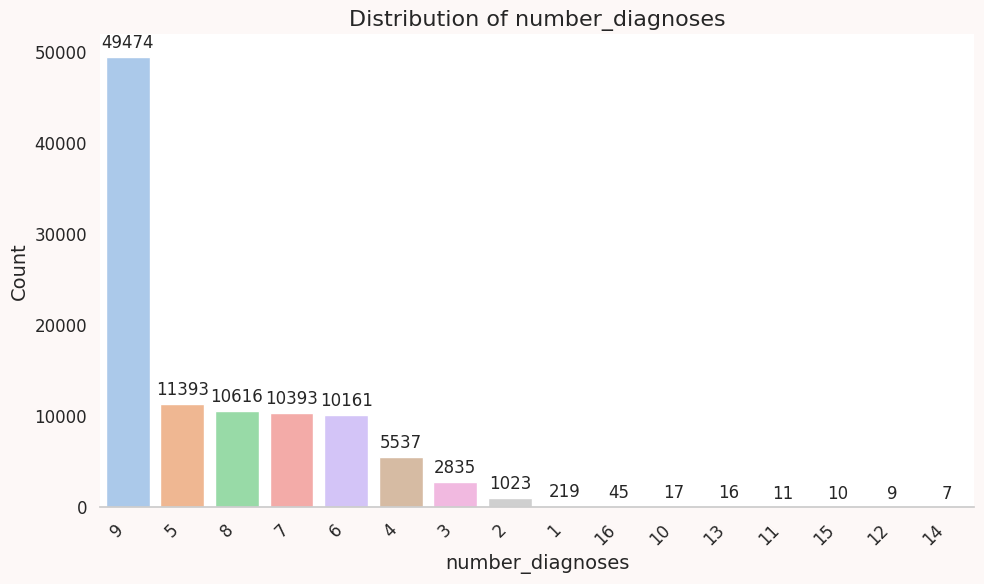

In [426]:
plot_feature_distribution(raw_data,'number_diagnoses')

####  Hospital visits 

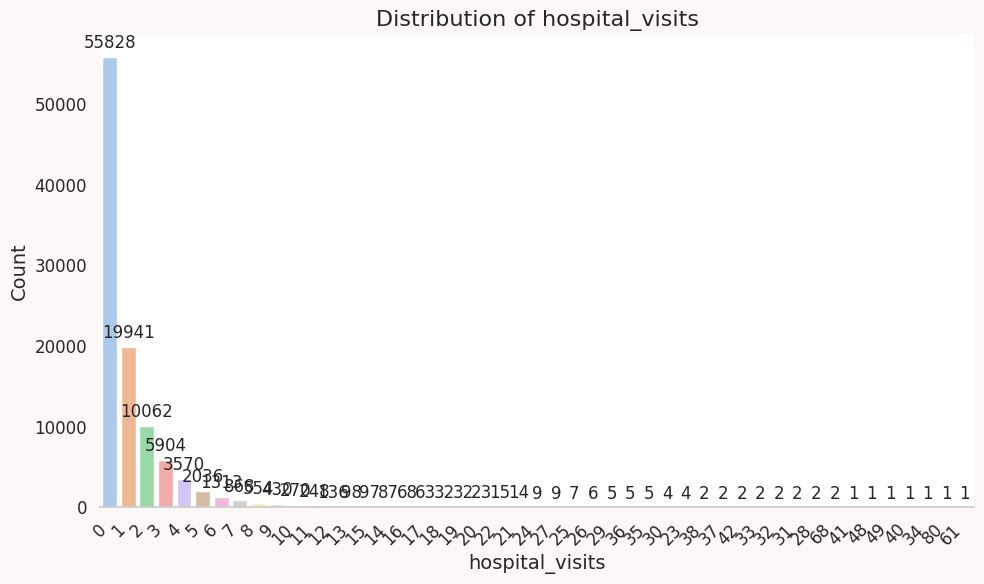

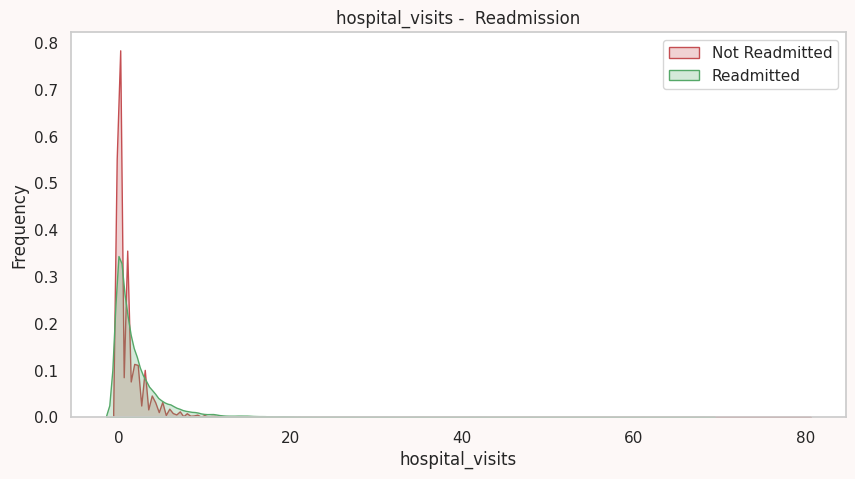

In [427]:
raw_data['hospital_visits'] = raw_data['number_outpatient'] + raw_data['number_emergency'] + raw_data['number_inpatient']

plot_feature_distribution(raw_data,'hospital_visits')
plot_prob_density(raw_data,'hospital_visits')

#### 23 columns for different medications

In [428]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'citoglipton',
'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin',
'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


med_values_map = {'No': 0, 'Steady': 0, 'Up': 1, 'Down': -1}

raw_data[meds] = raw_data[meds].replace(med_values_map) 
med_values_diff = raw_data[meds].diff(axis=1)
med_changes = med_values_diff.ne(0).sum(axis=1)
raw_data['num_med_changes'] = med_changes
raw_data['num_med_changes'].value_counts()


1    74063
3    25233
2     1044
5      808
4      511
6       82
7       21
8        4
Name: num_med_changes, dtype: int64

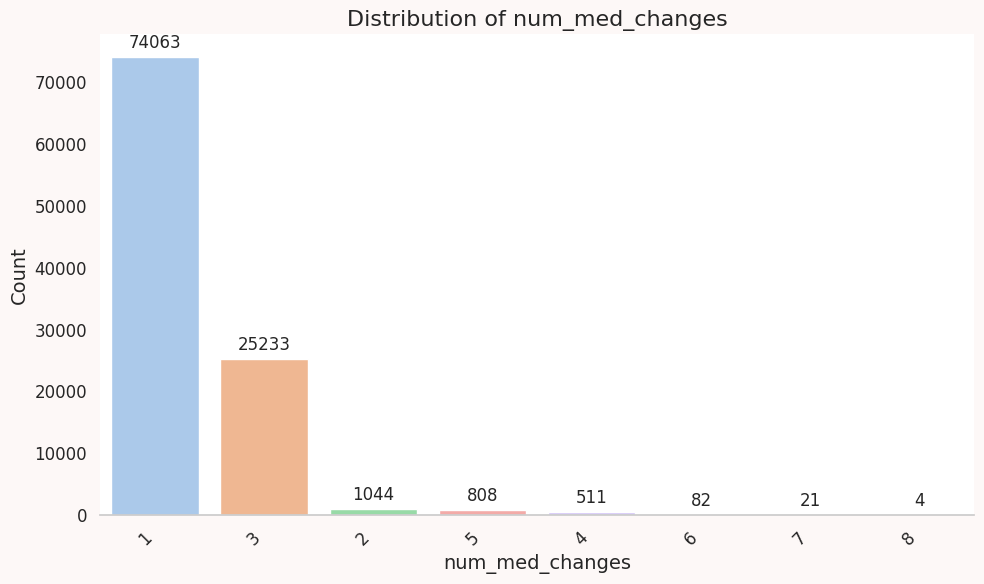

here


In [429]:
plot_feature_distribution(raw_data,'num_med_changes')
#cop['num_med_changes']


#### Identification columns 

### Influence of the different variables on the Target variable :

- Gender
- Race
- Age
- Insulin
- Changes in medication 
- Diabetes Medication 
- Glucose serum test results
- Number of lab procedures
- Number of medications used


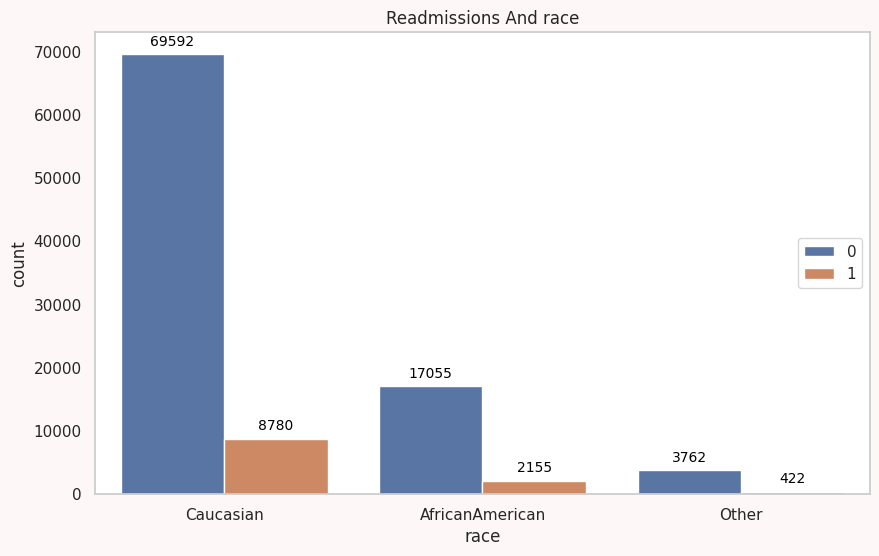

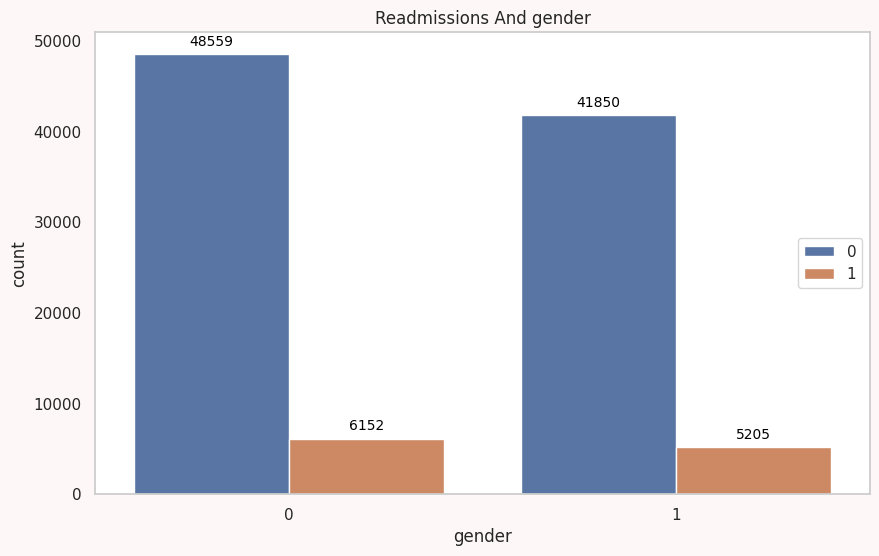

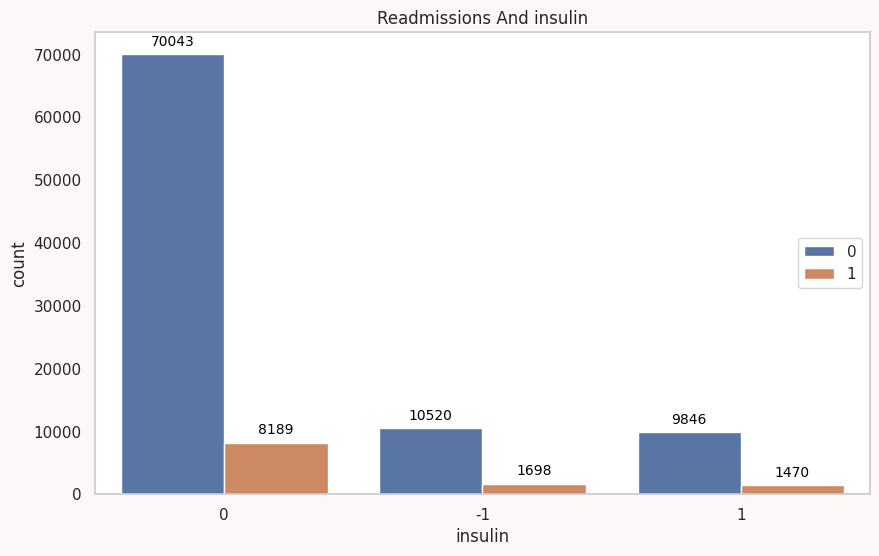

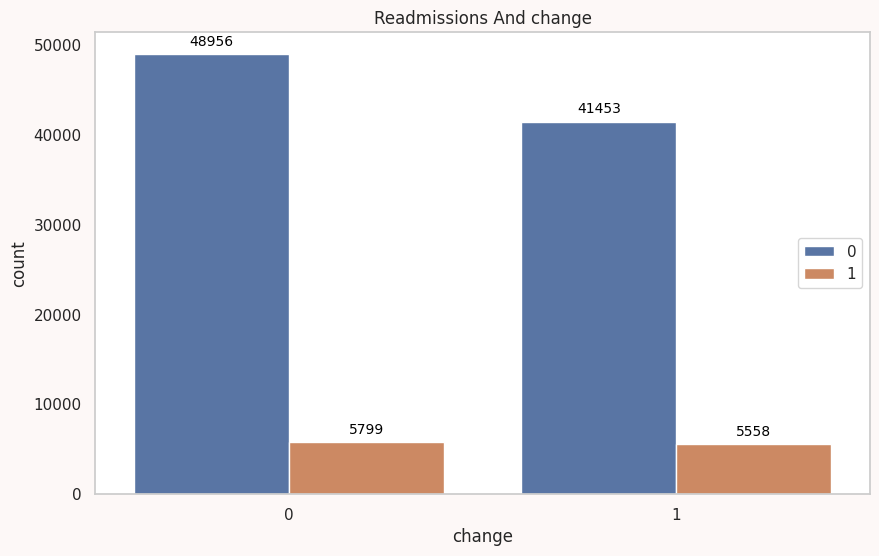

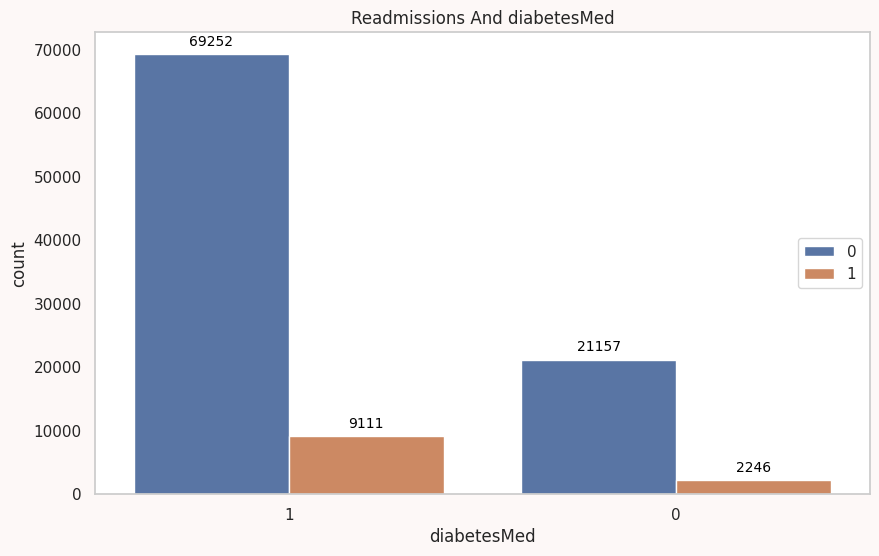

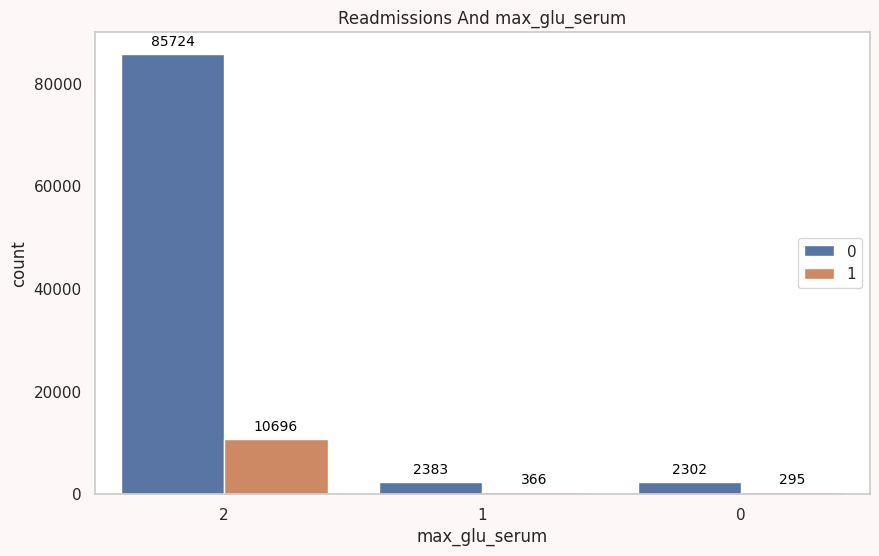

Text(0.5, 1.0, 'Readmission And Number of lab procedures')

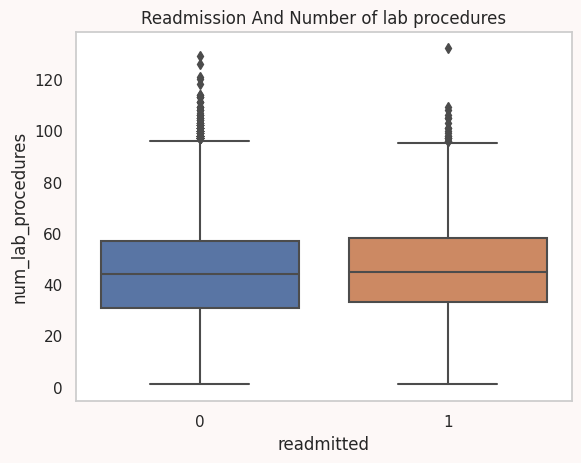

In [430]:
def plot_readmission_correlations(df,col):
    col_readmitted_group = raw_data.groupby([col,'readmitted']).readmitted.count()
    col_data = raw_data[col].unique().tolist()
    readmission = raw_data.readmitted.unique().tolist()
    
    readmitted = []
    for i in col_data:
        for j in readmission:
            if j == 1 :
                readmitted.append(col_readmitted_group[i][j])
            
    order = pd.DataFrame({'col': col_data, 'readmitted':readmitted}).sort_values(by='readmitted',ascending=False).col.tolist()
    
    #plot
    fig, ax =plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="readmitted", data=raw_data, palette="deep" ,order = order)
    
    ax.set_title('Readmissions And '+ col)
    ax.legend(loc='right')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4),
                    textcoords='offset points')
    plt.show()
     
    
plot_readmission_correlations(raw_data,"race")
plot_readmission_correlations(raw_data,"gender")
plot_readmission_correlations(raw_data,"insulin")
plot_readmission_correlations(raw_data,"change")
plot_readmission_correlations(raw_data,"diabetesMed")
plot_readmission_correlations(raw_data,"max_glu_serum")

sns.boxplot(x="readmitted", y="num_lab_procedures", data=raw_data).set_title('Readmission And Number of lab procedures')


# Pre-modelling

In [431]:
numerical_features = list(raw_data.select_dtypes(include=['number']).columns)
non_numerical_features = list(raw_data.select_dtypes(exclude=['number']).columns)

print(len(numerical_features) + len(non_numerical_features)) 

49


In [432]:
raw_data.dtypes

encounter_id                  int64
patient_nbr                   int64
race                         object
gender                        int64
age                         float64
admission_type_id           float64
discharge_disposition_id    float64
admission_source_id         float64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                   

# Modeling

### Logistic Regression

In [433]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

X = raw_data.drop('readmitted',axis = 1)
y = raw_data['readmitted']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)


# create a column transformer for one-hot encoding
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
preprocessor = make_column_transformer((OneHotEncoder(), categorical_cols), remainder='passthrough')
# fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
# transform the testing data
X_test_preprocessed = preprocessor.transform(X_test)


# fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# transform the testing data
X_test_preprocessed = preprocessor.transform(X_test)

# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the training data
logreg.fit(X_train_preprocessed, y_train)

# make predictions on the testing data
y_pred = logreg.predict(X_test_preprocessed)

# calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Accuracy: 0.8900425810678022
Confusion Matrix:
 [[27173     0]
 [ 3357     0]]
